In [19]:
import numpy as np
import open3d as o3d
import os
import cv2
import matplotlib.pyplot as plt

lidar_folder = "Q3folder/lidar_scans"
current_directory = os.getcwd()
lidar_files = []
for filename in os.listdir(lidar_folder):
    lidar_files.append(os.path.join(current_directory, lidar_folder, filename))

plane_normals = []
plane_offsets = []

for lidar_scan in lidar_files:
    cloud = o3d.io.read_point_cloud(lidar_scan)
    pcd = np.asarray(cloud.points)
    centroid = np.mean(pcd, axis=0)
    pcd = pcd - centroid

    u, sigma, v_t = np.linalg.svd(pcd.T @ pcd, full_matrices=False)
    normal = u[:, 2]

    offset = np.dot(normal, centroid)
    if offset < 0:
        offset = -offset
        normal = -normal

    plane_normals.append(normal.reshape(3))
    plane_offsets.append(offset)

    print("Normal vector:", normal)
    print("Offset:", offset)


Normal vector: [ 0.63693437 -0.76499839  0.09535237]
Offset: 4.993811298096003
Normal vector: [ 0.70169742 -0.70118932  0.1263102 ]
Offset: 4.72077965972876
Normal vector: [ 0.93809241 -0.22958973  0.25936688]
Offset: 5.204305546806318
Normal vector: [ 0.72352642 -0.68812782 -0.05467752]
Offset: 4.79350162621247
Normal vector: [ 0.83333533 -0.55208241  0.02751785]
Offset: 5.220803337324182
Normal vector: [ 0.91935323 -0.3607026   0.15710911]
Offset: 5.702524575286329
Normal vector: [0.94151039 0.18949708 0.27865578]
Offset: 6.323572215248566
Normal vector: [ 0.81878735  0.50763718 -0.26812639]
Offset: 6.445439719171264
Normal vector: [ 0.93288206 -0.2440387   0.26490788]
Offset: 5.6742584632412605
Normal vector: [ 0.95207118 -0.1539658   0.26430097]
Offset: 5.743694294895788
Normal vector: [ 0.60407281 -0.77412903  0.18926246]
Offset: 5.062352211986537
Normal vector: [ 0.75932657 -0.56254883  0.32705042]
Offset: 4.954015451590527
Normal vector: [ 0.47346333 -0.7599202  -0.44536924]
Off

![WhatsApp Image 2024-03-24 at 18.08.29_013bc42a.jpg](<attachment:WhatsApp Image 2024-03-24 at 18.08.29_013bc42a.jpg>)
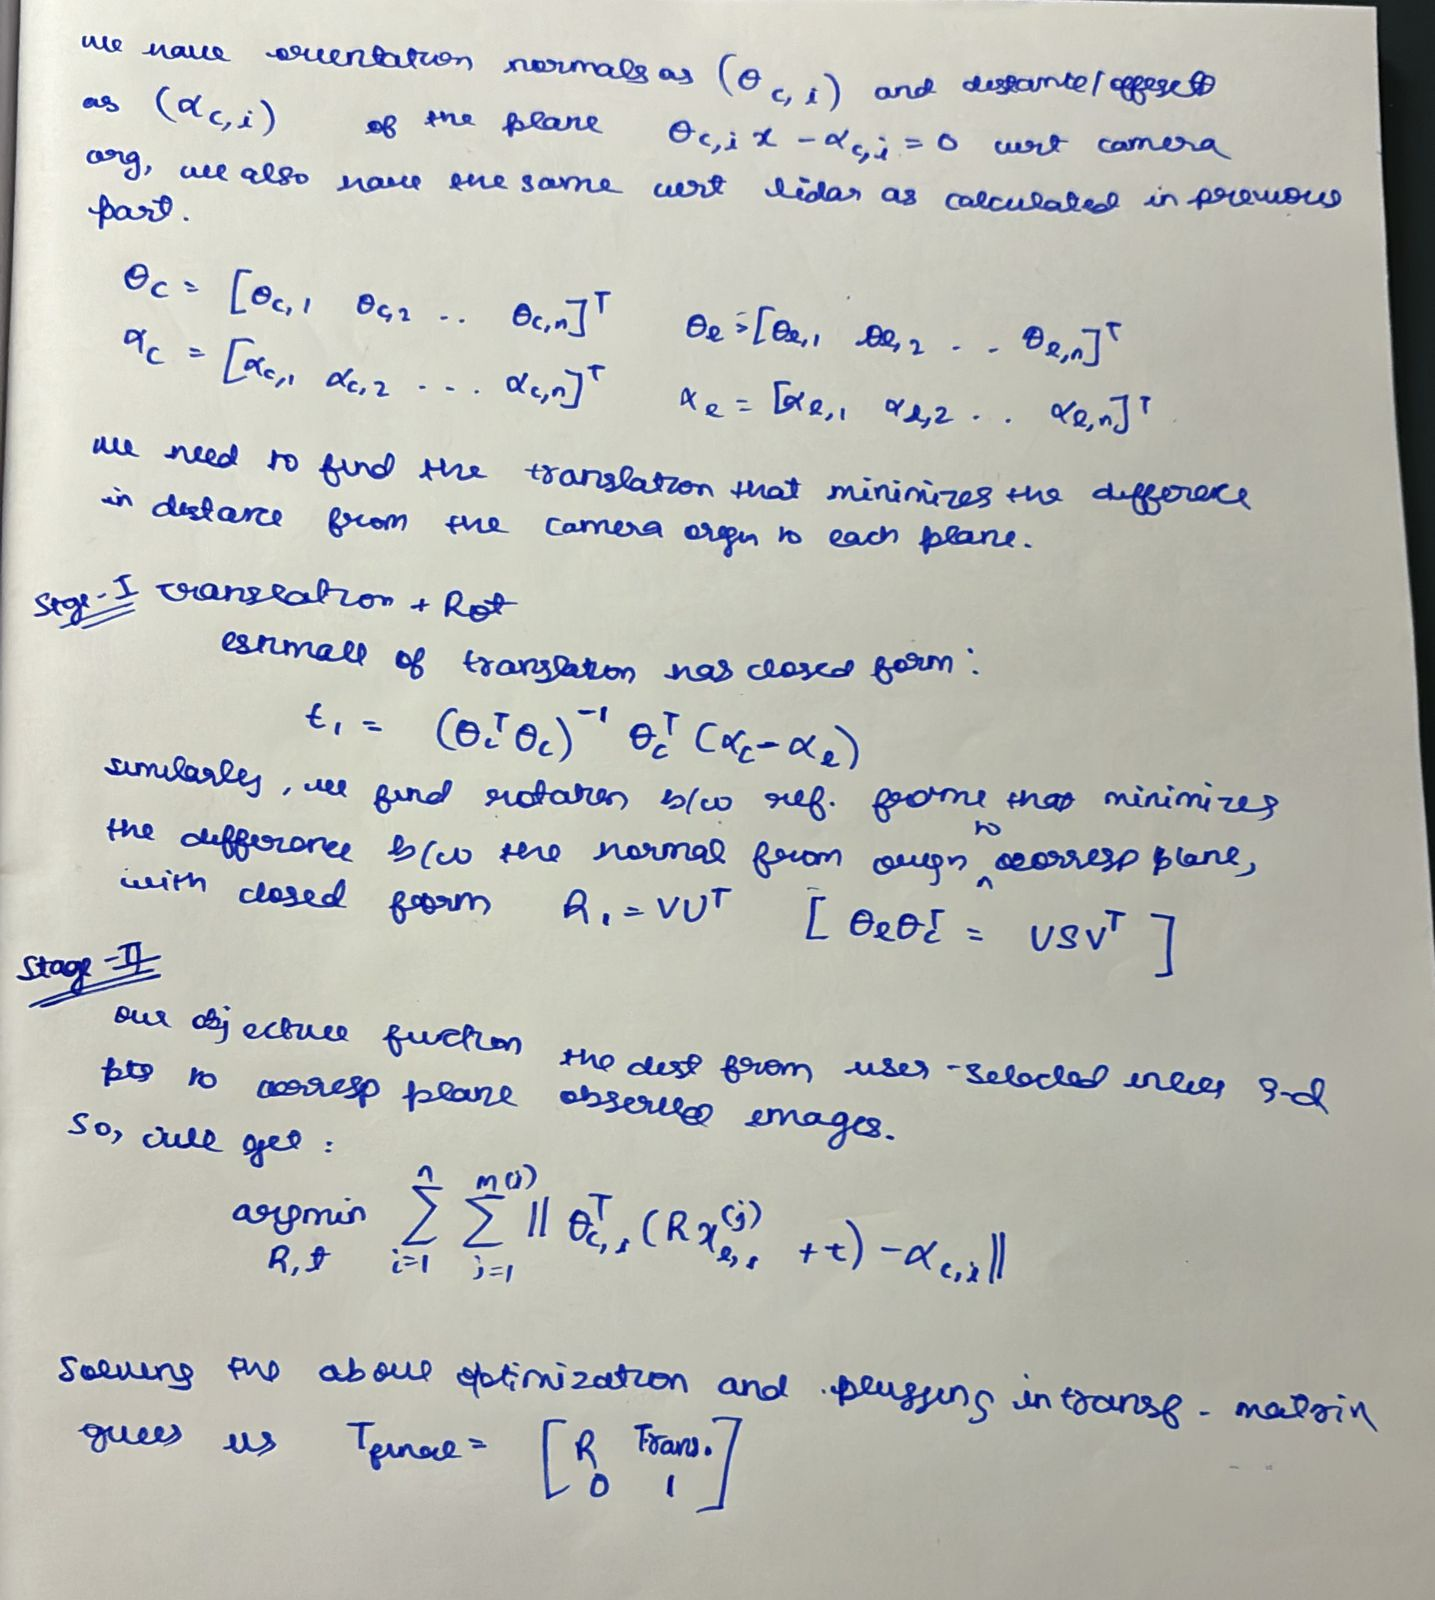

In [20]:
import os
import numpy as np

# Define numpy arrays for camera normals
alpha_c = np.array([])
theta_c = np.array([])
alpha_l = np.array([])
theta_l = np.array([])

camera_parameters = "Q3folder/camera_parameters"
current_directory = os.getcwd()
dirct = os.listdir(camera_parameters)
dirct = [x for x in dirct if x != 'camera_intrinsic.txt' and x != 'distortion.txt']

for i in range(len(dirct)): 
    # Load camera parameters 
    # Load translation vectors for camera
    camera_folder = os.path.join(current_directory, camera_parameters, dirct[i])
    translation_c = np.array(np.loadtxt(os.path.join(camera_folder, "translation_vectors.txt")))
    # Load normals for camera
    normal_camera = np.array(np.loadtxt(os.path.join(camera_folder, "camera_normals.txt")),  dtype=np.float32)

    # Adding lidar parameters
    alpha_l = np.append(alpha_l, plane_offsets[i])
    theta_l = np.append(theta_l, plane_normals[i])

    # Adding camera parameters
    translation_c = np.array([[translation_c[0], translation_c[1], translation_c[2]]])
    current_theta_c = np.array([[normal_camera[0], normal_camera[1], normal_camera[2]]])
    current_alpha_c = translation_c @ current_theta_c.T
    if(current_alpha_c < 0):
        current_alpha_c *=-1
        current_theta_c*=-1
        
    alpha_c = np.append(alpha_c, current_alpha_c)
    theta_c = np.append(theta_c, current_theta_c)

alpha_c = alpha_c.reshape((-1, 1))
alpha_l = alpha_l.reshape((-1, 1))
theta_l = theta_l.reshape((-1, 3))
theta_c = theta_c.reshape((-1, 3))

# Calculate T_1 (translation vector)
T_1 = np.linalg.inv(theta_c.T @ theta_c) @ theta_c.T @ (alpha_c - alpha_l)

# Calculate R_1 (rotation matrix)
u, s, vt = np.linalg.svd(theta_l.T @ theta_c)
R_1 = vt.T @ u.T

# Print the calculated values
print(f"Determinant of rotation matrix: {np.linalg.det(R_1)}")
print("The value of T_1 is", T_1)
print("The value of R_1 is", R_1)

# Finding the transformation matrix T
T = np.hstack((R_1, T_1))
T = np.vstack((T, np.array([0, 0, 0, 1])))
print("The value of T is:")
print(T)

Determinant of rotation matrix: 1.0000000000000002
The value of T_1 is [[ 0.08855656]
 [-0.36208152]
 [-0.59925674]]
The value of R_1 is [[-1.75158877e-01 -9.84540171e-01  1.36162323e-04]
 [ 1.53559962e-02 -2.87025846e-03 -9.99877970e-01]
 [ 9.84420419e-01 -1.75135412e-01  1.56213464e-02]]
The value of T is:
[[-1.75158877e-01 -9.84540171e-01  1.36162323e-04  8.85565632e-02]
 [ 1.53559962e-02 -2.87025846e-03 -9.99877970e-01 -3.62081517e-01]
 [ 9.84420419e-01 -1.75135412e-01  1.56213464e-02 -5.99256739e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


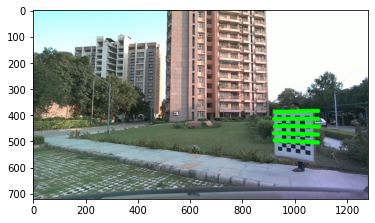

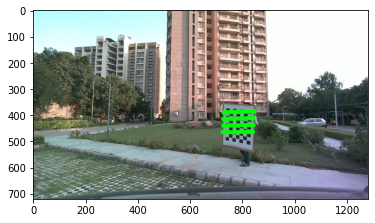

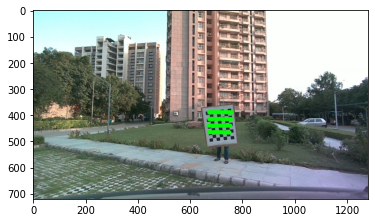

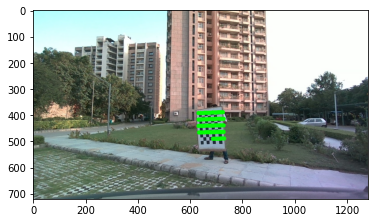

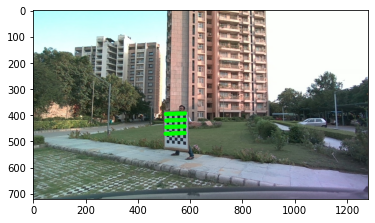

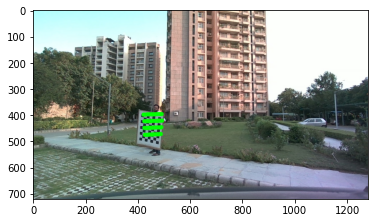

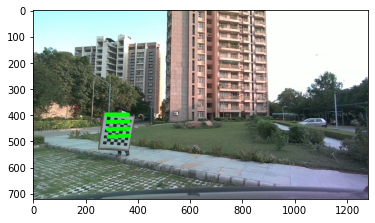

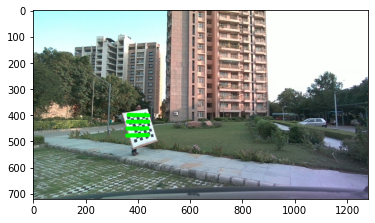

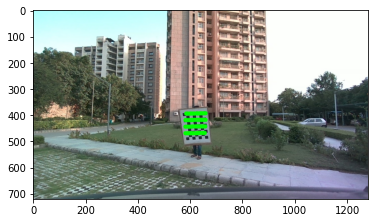

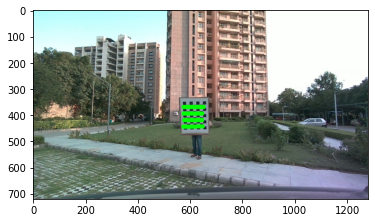

In [21]:
def load_camera_intrinsics(intrinsic_file):
    camera_parameters_dir = "Q3folder/camera_parameters"
    intrinsic = np.loadtxt(os.path.join(camera_parameters_dir, intrinsic_file))
    camera_matrix = np.zeros((3, 4))
    camera_matrix[:3, :3] = intrinsic
    return camera_matrix

def project_points_to_camera(lidar_scan_file, intrinsic_matrix, transform_matrix):

    # Load the lidar point cloud
    lidar_point_cloud = o3d.io.read_point_cloud(lidar_scan_file)
    lidar_points = np.asarray(lidar_point_cloud.points)

    # Load the corresponding image
    img_name = lidar_scan_file.split('/')[-1].split('.')[0][12:]
    img = cv2.imread(f"Q3folder/camera_images/{img_name}.jpeg")

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rtrn, corners = cv2.findChessboardCorners(gray_img, (8, 6), None)
    points_homogeneous = np.hstack((lidar_points, np.ones((len(lidar_points), 1))))
    camera_points = (intrinsic_matrix @ transform_matrix @ points_homogeneous.T).T

    if rtrn:
        projections = []
        for current_point in camera_points:
            normalized_point = current_point / current_point[2]
            projections.append(normalized_point[:2])
        return np.array(projections)
    else:
        return None

def visualize_projections(lidar_files, projections):
    for index, lidar_scan_file in enumerate(lidar_files):
        img_name = lidar_scan_file.split('/')[-1].split('.')[0][12:]
        img = cv2.imread(f"Q3folder/camera_images/{img_name}.jpeg")
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        rtrn, corners = cv2.findChessboardCorners(gray_img, (8, 6), None)
        if rtrn:
            points = projections[index]
            for point in points:
                cv2.circle(gray_img, (int(round(point[0])), int(round(point[1]))), 8, (0, 255, 0), -1)

        plt.imshow(gray_img)
        plt.show()

intrinsic_file = 'camera_intrinsic.txt'
camera_intrinsic_matrix = load_camera_intrinsics(intrinsic_file)

projection_results = []
for lidar_scan_file in lidar_files:
    projection_result = project_points_to_camera(lidar_scan_file, camera_intrinsic_matrix, T)
    if projection_result is not None:
        projection_results.append(projection_result)

visualize_projections(lidar_files[:10], projection_results)


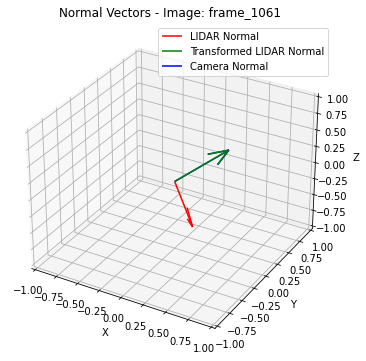

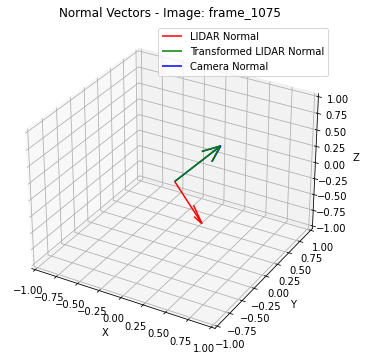

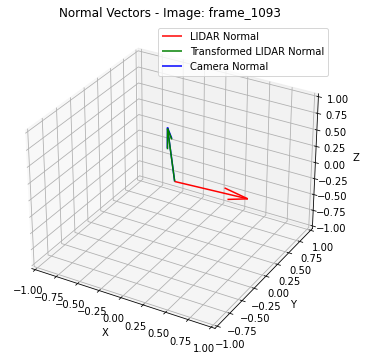

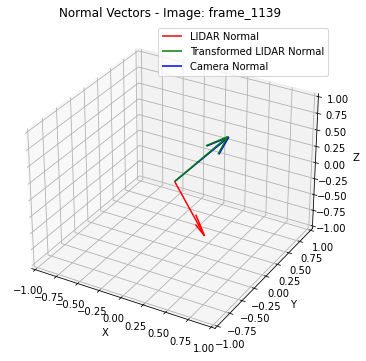

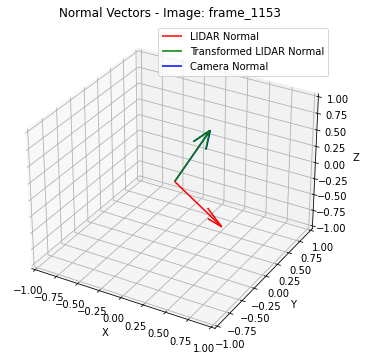

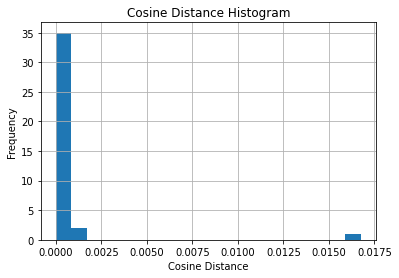

Average error: 0.0006469020879404696
Standard deviation: 0.0026609995346112752


In [22]:
from scipy.spatial.distance import cosine

# Plot the normal vectors for any 5 image and LIDAR scan pairs
def plot_normal_vectors(lidar_files, plane_normals, theta_c, R_1, T_1, num_pairs=5):
    for i in range(num_pairs):
        lidar_scan_file = lidar_files[i]
        img_name = lidar_scan_file.split('/')[-1].split('.')[0][12:]
        lidar_normal = plane_normals[i]
        transformed_lidar_normal = R_1 @ lidar_normal
        camera_normal = theta_c[i]

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.quiver(0, 0, 0, lidar_normal[0], lidar_normal[1], lidar_normal[2], color='r', label='LIDAR Normal')
        ax.quiver(0, 0, 0, transformed_lidar_normal[0], transformed_lidar_normal[1], transformed_lidar_normal[2], color='g', label='Transformed LIDAR Normal')
        ax.quiver(0, 0, 0, camera_normal[0], camera_normal[1], camera_normal[2], color='b', label='Camera Normal')
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Normal Vectors - Image: {img_name}')
        ax.legend()
        plt.show()

# Compute the cosine distance between camera normal and transformed LIDAR normal for all pairs
def compute_cosine_distances(plane_normals, theta_c, R_1):
    cosine_distances = []
    for i in range(len(plane_normals)):
        cosine_distances.append(cosine(theta_c[i], R_1 @ plane_normals[i]))
    return cosine_distances

# Plot histogram of cosine distances
def plot_cosine_distance_histogram(cosine_distances):
    plt.hist(cosine_distances, bins=20)
    plt.title('Cosine Distance Histogram')
    plt.xlabel('Cosine Distance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot normal vectors for any 5 image and LIDAR scan pairs
plot_normal_vectors(lidar_files[:5], plane_normals[:5], theta_c, R_1, T_1)

# Compute cosine distances between camera normal and transformed LIDAR normal for all pairs
cosine_distances = compute_cosine_distances(plane_normals, theta_c, R_1)

# Plot histogram of cosine distances
plot_cosine_distance_histogram(cosine_distances)

# Reproting errors
print(f"Average error: {np.mean(cosine_distances)}")
print(f"Standard deviation: {np.std(cosine_distances)}")
